Setting up the environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/Marble

[Errno 2] No such file or directory: 'gdrive/MyDrive/Marble'
/content/gdrive/MyDrive/Marble


Imports and paths

In [ ]:
import os
import time
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, Grayscale, transforms, ToTensor
from torchvision.transforms import functional as F
import torch
import torchvision
import warnings
from PIL import Image
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import json

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

warnings.filterwarnings("ignore")

In [ ]:
dataset_path = "./new_dataset"
masks_dir = os.path.join(dataset_path,"labels")
images_dir = os.path.join(dataset_path,"images")
save_path = "./saved_model"

LABEL = {
    "oyster": 1,
    "plankton": 2
}

Custom Dataset class that handles all the functionality necessary for training the neural network

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, ):
      self.labels_dir = labels_dir
      self.img_dir = img_dir
      self.len = len(os.listdir(img_dir))

      self.transform = transform

      self.resize = Resize((150,150))
      self.to_grayscale = Grayscale()
      self.to_tensor = ToTensor()

    def __len__(self):
      return self.len

    def __getitem__(self, idx):

      img_name = f"image_{str(idx).zfill(3)}.png"
      bbox_name = f"image_{str(idx).zfill(3)}.xml"

      img_path = os.path.join(self.img_dir, img_name)
      bbox_file_path = os.path.join(self.labels_dir, bbox_name)

      image = Image.open(img_path).convert("RGB")  # Open image and convert to RGB format
      original_img_size = image.size

      bboxes, labels = self.parse_xml(bbox_file_path)

      labels = [LABEL[l] for l in labels]

      image = self.resize(image)
      image = self.to_grayscale(image)


      bboxes = [self.resize_bbox(bbox, original_img_size, image.size) for bbox in bboxes]
      bboxes = [torch.tensor(bbox).to(device) for bbox in bboxes]

      if self.transform:
          image = self.transform(image)
      image = self.to_tensor(image)

      return image, labels, bboxes

    def resize_bbox(self, bbox, orig_size, new_size):
      orig_width, orig_height = orig_size
      new_width, new_height = new_size

      x, y, w, h = bbox
      x_scale = new_width / orig_width
      y_scale = new_height / orig_height

      new_x = int(x * x_scale)
      new_y = int(y * y_scale)
      new_w = int(w * x_scale)
      new_h = int(h * y_scale)

      return [new_x, new_y, new_w, new_h]

    def parse_xml(self, xml_file_path):
      tree = ET.parse(xml_file_path)
      root = tree.getroot()

      num_objects = len(root.findall('object'))
      bboxes = np.zeros((num_objects, 4), dtype=np.int32)
      labels = []

      for i, obj in enumerate(root.findall("object")):
        label = obj.find("name").text
        bbox_element = obj.find("bndbox")

        bboxes[i] = [
            int(bbox_element.find("xmin").text),
            int(bbox_element.find("ymin").text),
            int(bbox_element.find("xmax").text),
            int(bbox_element.find("ymax").text)
        ]
        labels.append(label)

      return bboxes, labels

    def pad_bboxes(self, bboxes, max_num_bboxes):
        num_bboxes = len(bboxes)
        if num_bboxes < max_num_bboxes:
            # Pad the bounding boxes with dummy bounding boxes
            pad_bboxes = torch.zeros(max_num_bboxes - num_bboxes, 4, dtype=torch.int32)
            bboxes = torch.cat((bboxes, pad_bboxes), dim=0)
        return bboxes


Some important functions

In [ ]:
from torchvision.ops import nms

def visualize(image, output_dict, threshold=0.75):
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image.permute(1, 2, 0).cpu().numpy(), cv2.COLOR_BGR2RGB))

    boxes = output_dict['boxes'].cpu()
    labels = output_dict['labels'].cpu()
    scores = output_dict['scores'].cpu()

    ## TESTIRATI!
    test = nms(boxes, scores, 0.1)
    boxes = boxes[test]
    #print(test)

    for box, label, score in zip(boxes, labels, scores):
      if score > threshold:
          box = [box[0], box[1], box[2] - box[0], box[3] - box[1]]  # Convert [x1, y1, x2, y2] to [x, y, width, height]
          rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
          ax.add_patch(rect)
          plt.text(box[0], box[1], f'Class: {label.item()}, Score: {score.item():.2f}', color='r')

    plt.show()

In [ ]:
def visualize_single_prediction(image, bounding_boxes, labels, scores, threshold=0.75):
  fig, ax = plt.subplots(1)
  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  test = nms(bounding_boxes, scores, 0.1)
  bounding_boxes = bounding_boxes[test]

  for (box, label, score) in zip(bounding_boxes, labels, scores):

    if score>threshold:
      plt.text(box[0], box[1], f'Class: {label.item()}, Score: {score.item():.2f}', color='r')
      points = np.array(box, np.int32)
      polygon = patches.Rectangle((points[0], points[1]), points[2] - points[0], points[3] - points[1], edgecolor="g", linewidth=2, fill=False)
      ax.add_patch(polygon)
  plt.show()

In [ ]:
def check_accuracy(loader, model):

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
          print(len(images))

          images = images.to(device)
          image_sizes = [img.shape[-2:] for img in images]

          outputs = model(images, targets)
          for i, output in enumerate(outputs):
            visualize(images[i], output, 0.8)


Training the Faster-RCNN network with a ResNet50 backbone on our dataset. The loss function used is CrossEntropy Error and the Optimizer is Adam.

We are using an 80-10-10 training, validation and test split.

Our images get resized to 150, 150 and used only in grayscale.



The parameters we are using are:

*   Learning rate: 0.0001
*   Number of epochs: 20
*   Batch size: 4
*   Patience: 3






In [ ]:
def custom_collate_fn(batch):
    images = [image.to(device) for image, _, _ in batch]
    targets = []

    for _, labels, boxes in batch:
        boxes = [torch.tensor(box).to(device, dtype=torch.float32) for box in boxes]
        labels = torch.tensor(labels).to(device, dtype=torch.int64)
        target = {'boxes': torch.stack(boxes), 'labels': labels}
        targets.append(target)
    return torch.stack(images), targets


timestr = time.strftime("%d_%m_%y-%H_%M_%S")
model_name = f"{save_path}_{timestr}.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channel = 3
num_classes = 3
learning_rate = 1e-4
batch_size = 4
num_epochs = 20
patience = 3

weights = [1, 1]
weights = torch.FloatTensor(weights)

train_averages = []
val_averages = []

# Original train dataset

dataset = CustomImageDataset(masks_dir, images_dir)
train_set, temp_set = torch.utils.data.random_split(dataset, [int(0.8*200), len(dataset)-int(0.8*200)])

test_set, validation_set = torch.utils.data.random_split(temp_set, [int(0.5*len(temp_set)), len(temp_set)-int(0.5*len(temp_set))])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, collate_fn = custom_collate_fn)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, collate_fn = custom_collate_fn)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False, collate_fn = custom_collate_fn)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


best_valid_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    losses = []

    for batch_idx, (images, targets) in enumerate(train_loader):

        model.train()

        output = model(images, targets)

        # Calculate the loss based on the model output
        loss = output["loss_classifier"]

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    valid_losses = []
    with torch.no_grad():
      for data, targets in validation_loader:
          data = data.to(device)
          val_losses = model(data, targets)

          loss_classifier = val_losses["loss_classifier"]
          valid_loss += loss_classifier.item()
          valid_losses.append(valid_loss)
    average_train_loss = sum(losses)/len(losses)
    average_val_loss = sum(valid_losses)/len(valid_losses)

    train_averages.append(average_train_loss)
    val_averages.append(average_val_loss)

    print(f'Train loss at epoch {epoch} is {average_train_loss}')
    print(f'Validation loss at epoch {epoch} is {average_val_loss}')
    print("---------------------------------")

    if average_val_loss < best_valid_loss:
        best_valid_loss = average_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. No improvement for", patience, "epochs.")
        break

Train loss at epoch 0 is 0.12097175004892051
Validation loss at epoch 0 is 0.2987383267340752
---------------------------------
Train loss at epoch 1 is 0.041989293275401
Validation loss at epoch 1 is 0.21676375143803084
---------------------------------
Train loss at epoch 2 is 0.030664060590788723
Validation loss at epoch 2 is 0.20510051865130663
---------------------------------
Train loss at epoch 3 is 0.04035034531261772
Validation loss at epoch 3 is 0.19783023229012123
---------------------------------
Train loss at epoch 4 is 0.029475275659933686
Validation loss at epoch 4 is 0.19235451784558022
---------------------------------
Train loss at epoch 5 is 0.02538793543353677
Validation loss at epoch 5 is 0.17418164802858463
---------------------------------
Train loss at epoch 6 is 0.025092047080397605
Validation loss at epoch 6 is 0.15717611311433408
---------------------------------
Train loss at epoch 7 is 0.02391045039985329
Validation loss at epoch 7 is 0.18873630141696104
--

Plotting the training and validation loss throughout the epochs

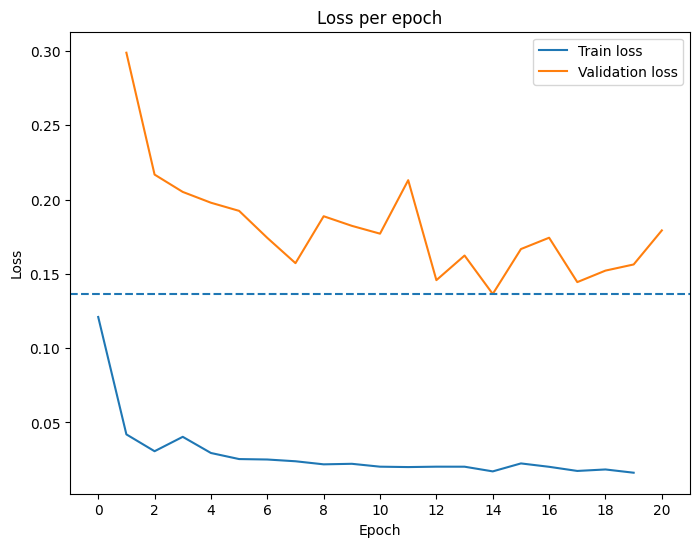

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(range(len(train_averages)), train_averages)
ax.plot(range(1, len(val_averages) + 1,), val_averages)
ax.legend(["Train loss", "Validation loss"])

plt.xticks(range(0, len(val_averages)+1,2))
ax.axhline(val_averages[13], ls='--')
ax.set(title="Loss per epoch", xlabel="Epoch", ylabel="Loss");

Model accuracy checks

In [ ]:
print("Checking accuracy on Train")
check_accuracy(train_loader, model)

In [ ]:
print("Checking accuracy on Test")
check_accuracy(test_loader, model)

Saving and loading the model weights

In [ ]:
## Saving the model
torch.save(model.state_dict(), model_name)
print(f"Model saved: {model_name}")

Model saved: ./saved_model_29_08_23-12_13_19.pt


In [ ]:
new_device_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=3)
saved_state_dict = torch.load("./saved_model_29_08_23-12_13_19.pt")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose the device
new_device_model.to(device)

# Load the state dictionary into the model
new_device_model.load_state_dict(saved_state_dict)
new_device_model.eval();


Function to count larvae per loaded image.

This was a placeholder for the function used by the floater which reads it from the /microscope topic, rather than a path

In [ ]:
import torch
from torchvision.ops import nms
from torchvision.transforms import Resize, Grayscale, transforms, ToTensor
from PIL import Image

def count_larvae(model, img_in, iou_threshold = 0.15):
  model.eval()

  image = Image.open(img_in)
  image = image.convert("RGB")

  tfs = transforms.Compose([
      transforms.Resize((150,150)),
      transforms.Grayscale(),
      transforms.ToTensor()
  ])
  img = tfs(image).unsqueeze(0).cuda()

  output = model(img)
  output_boxes = output[0]["boxes"].cpu().detach()
  output_scores = output[0]["scores"].cpu().detach()
  output_labels = output[0]["labels"].cpu().detach()

  image_np = np.array(image.resize((150,150)))

  keep = nms(output_boxes, output_scores, iou_threshold)

  filtered_boxes = output_boxes[keep]
  filtered_labels = output_labels[keep]

  num_oysters = (filtered_labels == 1).sum().item()

  print(f"Found: {num_oysters}")
  return num_oysters

In [ ]:
count_larvae(new_device_model, "./dataset/oyster_larvae/grouped/image_012.png")

Found: 80
------------------------


Example prediction over one image

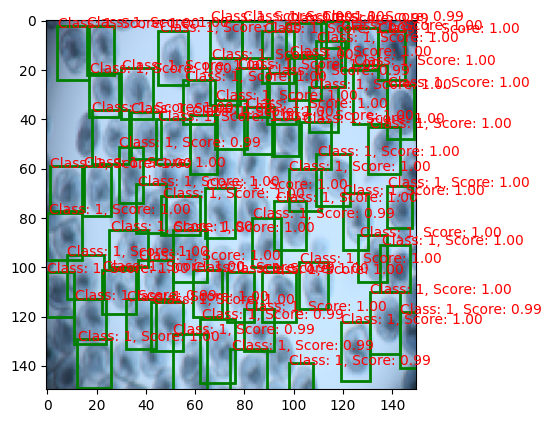

In [ ]:

new_device_model.eval()

image = Image.open("./dataset/oyster_larvae/grouped/image_012.png")
image = image.convert("RGB")

tfs = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(),
    transforms.ToTensor()
])
img = tfs(image).unsqueeze(0).cuda()

output = new_device_model(img)
output_boxes = output[0]["boxes"].cpu().detach()
output_scores = output[0]["scores"].cpu().detach()
output_labels = output[0]["labels"].cpu().detach()

image_np = np.array(image.resize((150,150)))


visualize_single_prediction(image_np, output_boxes, output_labels, output_scores)

Example of predictions over whole dataset, without boxes!

In [ ]:
model.eval()  # Set the model to evaluation mode

for batch_idx, (images, targets) in enumerate(train_loader):
    with torch.no_grad():
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        # Apply NMS and count oysters
        for i, output in enumerate(outputs):
            boxes = output['boxes']
            scores = output['scores']
            labels = output['labels']  # Assuming label 1 is for oysters

            iou_threshold = 0.15

            keep = nms(boxes, scores, iou_threshold)

            filtered_boxes = boxes[keep]
            filtered_labels = labels[keep]

            num_oysters = (filtered_labels == 1).sum().item()
            print(f"Number of oysters in image {i}: {num_oysters}")

            image_np = np.array(images[i].resize((150,150)))
            visualize_single_prediction(image_np, boxes, labels, scores)

TODO: Fine tuning of the model

In [ ]:
# Probavamo finetunat
dataset_path = "./new_dataset"
masks_dir = os.path.join(dataset_path,"labels")
images_dir = os.path.join(dataset_path,"images")

dataset_finetune = CustomImageDataset(masks_dir, images_dir)

train_size_finetune = int(0.8 * len(dataset_finetune))
train_dataset_finetune, temp_dataset_finetune = torch.utils.data.random_split(dataset_finetune, [train_size_finetune, len(dataset_finetune) - train_size_finetune])

test_size_finetune = len(temp_dataset_finetune) // 2
test_dataset_finetune, validation_dataset_finetune = torch.utils.data.random_split(temp_dataset_finetune, [test_size_finetune, len(temp_dataset_finetune) - test_size_finetune])

train_loader_finetune = DataLoader(dataset=train_dataset_finetune, batch_size=batch_size, shuffle=True, collate_fn = custom_collate_fn)
test_loader_finetune = DataLoader(dataset=test_dataset_finetune, batch_size=batch_size, shuffle=False, collate_fn = custom_collate_fn)

for epoch in range(num_epochs):
    losses = []

    for batch_idx, (images,targets) in enumerate(train_loader_finetune):

        model.train()

        output = model(images, targets)

        # Calculate the loss based on the model output
        #loss_dict = output['losses']
        loss = output["loss_classifier"]

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\nCost at epoch {epoch} is {sum(losses)/len(losses)}')